<a href="https://colab.research.google.com/github/evanzzer/film-system-recommendation/blob/main/Film_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation

## About the Dataset

These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

## File that will be used

- `movies_metadata.csv`: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.
- `ratings_small.csv`: The subset of 100,000 ratings from 700 users on 9,000 movies. (Original Rating Dataset has 26 millions)

## Data Preparation

Datasets are first fetched from Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -pv /root/.kaggle
!cp -v /content/drive/MyDrive/kaggle.json /root/.kaggle
!kaggle datasets download -d rounakbanik/the-movies-dataset

mkdir: created directory '/root/.kaggle'
'/content/drive/MyDrive/kaggle.json' -> '/root/.kaggle/kaggle.json'
 90% 205M/228M [00:01<00:00, 139MB/s]
100% 228M/228M [00:02<00:00, 117MB/s]


In [3]:
!unzip /content/the-movies-dataset.zip

Archive:  /content/the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


Next, we put `movies_metadata.csv` and `ratings_small.csv` to dataframe.

In [4]:
import pandas as pd 

movie  = pd.read_csv('movies_metadata.csv')
rating = pd.read_csv('ratings_small.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Now we check `movies_metadata.csv` and `ratings_small.csv` column information

In [5]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [6]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Check if the data is null

In [7]:
movie.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [8]:
rating.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

## Data Processing

We will be using Collaborative Learning. Hence, we will only include important rows.

From `movie` dataframe, we will be using `id`, `genres`, and `title`.

From `rating` dataframe, we will be using `userId`, `movieId`, and `rating`.

In [9]:
movie = movie[['id', 'title', 'genres']]
movie.head()

,id,title,genres
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]"


In [10]:
rating = rating[['userId', 'movieId', 'rating']]
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


The `genres` is in JSON format and we only want to extract the `name` part. Hence, we will be converting from JSON into String

In [11]:
import json

def convertGenre(string):
    genres = json.loads(string.replace("'", '"'))
    parsed_genres = [genre["name"] for genre in genres]
    return ", ".join(parsed_genres)

genres = movie.pop('genres').tolist()
movie['genres'] = [convertGenre(x) for x in genres]
movie.head()

,id,title,genres
0,862,Toy Story,"Animation, Comedy, Family"
1,8844,Jumanji,"Adventure, Fantasy, Family"
2,15602,Grumpier Old Men,"Romance, Comedy"
3,31357,Waiting to Exhale,"Comedy, Drama, Romance"
4,11862,Father of the Bride Part II,Comedy


Check movie total data and movie unique data

In [12]:
print(f"Total Data : {len(movie)}")
print(f"Unique Data: {len(movie.id.unique())}")

Total Data : 45466
Unique Data: 45436


There is some duplicates in the data. Therefore, we need to clean the duplicates.

In [13]:
movie = movie.drop_duplicates('id')
print(f"Total Unique Data after cleaning duplicates: {len(movie)}")

Total Unique Data after cleaning duplicates: 45436


Now we want to list movie that is also exist in Rating, and vice versa. Therefore, we want to filter so that `movieId` in `rating` and `id` in `movie` are both exists.

In [14]:
# Filter movie dataset so that only movieId in rating is exist in movie dataset
movie = movie[movie['id'].isin(rating.movieId.map(lambda x: str(x)))]
print(f"Filtered Movie Dataset : {movie.shape[0]}")

# Filter rating dataset so that only id in movie is exist in rating dataset
rating = rating[rating['movieId'].isin(movie.id.map(lambda x: int(x)))]
print(f"Filtered Rating Dataset: {rating.shape[0]}")

Filtered Movie Dataset : 2830
Filtered Rating Dataset: 44989


The data is now containing only IDs that we want to process. Now we can proceed into developing the model by using Collaborative Learning.

## Model Development

Before we model our data, we need to process everything to make sure the model can be made. We first process all unique values in `userId` and `movieId`

In [15]:
# Make list of Unique User ID
user_ids = rating['userId'].unique().tolist()

print(f"List  ID: {user_ids}")
print(f"Total ID: {len(user_ids)}")

# Encoded User ID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}

# Decoded User ID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

List  ID: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

Encoding `userId` is done. Next, we will be processing `movieId`.

In [16]:
# Make list of Unique Movie ID
movie_ids = rating['movieId'].map(lambda x: str(x)).unique().tolist()
print(f"List  ID: {movie_ids}")
print(f"Total ID: {len(movie_ids)}")

# Encoded Movie ID
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Decoded Movie ID
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

List  ID: ['1371', '1405', '2105', '2193', '2294', '2455', '17', '62', '110', '144', '150', '153', '161', '165', '168', '185', '186', '222', '223', '225', '235', '248', '253', '261', '265', '266', '272', '273', '292', '296', '300', '314', '317', '319', '339', '349', '350', '364', '377', '405', '410', '454', '457', '468', '480', '497', '500', '508', '509', '527', '537', '539', '550', '551', '552', '585', '586', '587', '588', '590', '592', '593', '616', '661', '247', '267', '318', '595', '778', '866', '1271', '1378', '1580', '1721', '1884', '2028', '2694', '2762', '2841', '2959', '44191', '58559', '112', '141', '173', '260', '289', '329', '380', '431', '434', '435', '440', '442', '464', '541', '594', '596', '858', '903', '910', '913', '919', '1073', '1089', '1125', '1127', '1213', '1257', '1259', '1265', '1278', '1282', '1285', '1372', '1374', '1376', '1377', '1380', '1387', '1396', '1544', '1858', '1917', '1918', '1954', '1961', '1967', '1968', '1994', '2000', '2002', '2003', '2005', '2

Next, we map the `userId` and `movieId` to the dataframe by mapping them with the encoded respective code.

In [17]:
rating['user'] = rating['userId'].map(user_to_user_encoded)
rating['movie'] = rating['movieId'].map(lambda x: str(x)).map(movie_to_movie_encoded)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now we want to find out the minimum and the maximum of the rating.

In [18]:
min_rating = min(rating['rating'])
max_rating = max(rating['rating'])
print(f"Min Rating: {min_rating}, Max Rating: {max_rating}")

Min Rating: 0.5, Max Rating: 5.0


Now we can determine the x and the y values.

In [19]:
x = rating[['user', 'movie']].values
y = rating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

We split the train and test data into 4:1 proportions.

In [20]:
train_indices = int(0.8 * rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [670 578]
 [670 581]
 [670 204]] [0.44444444 0.11111111 0.77777778 ... 0.66666667 0.88888889 0.77777778]


The data is now ready to be modeled. Next, we move on to the training process.

## Training

We first define the layers that will be needed for training

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class RecommenderNet(tf.keras.Model):
 
    # Insialisasi fungsi
    def __init__(self, num_users, num_movie, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movie = num_movie
        self.embedding_size = embedding_size

        # User Embedded Layer
        self.user_embedding = layers.Embedding( 
            num_users,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)   # User Embedded Layer Bias

        # Movie Embedded Layer
        self.movie_embedding = layers.Embedding(
            num_movie,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movie, 1)  # Movie Embedded Layer Bias
 
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])    # Call Embedded Layer #1
        user_bias = self.user_bias(inputs[:, 0])          # Call Embedded Layer #2
        movie_vector = self.movie_embedding(inputs[:, 1]) # Call Embedded Layer #3
        movie_bias = self.movie_bias(inputs[:, 1])        # Call Embedded Layer #4
    
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
    
        x = dot_user_movie + user_bias + movie_bias
        
        return tf.nn.sigmoid(x) # sigmoid activation

Now we compile our model with `BinaryCrossentropy()` Loss Function, `Adam()` optimizer with `lr=1e-3` and `RMS Error` metrics.

In [22]:
model = RecommenderNet(len(user_ids), len(movie_ids), 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

Now we can start our training

In [23]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
1125/1125 [==============================] - 5s 3ms/step - loss: 0.6429 - root_mean_squared_error: 0.2498 - val_loss: 0.6781 - val_root_mean_squared_error: 0.2847
Epoch 2/100
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6103 - root_mean_squared_error: 0.2174 - val_loss: 0.6727 - val_root_mean_squared_error: 0.2801
Epoch 3/100
1125/1125 [==============================] - 4s 3ms/step - loss: 0.6024 - root_mean_squared_error: 0.2093 - val_loss: 0.6676 - val_root_mean_squared_error: 0.2756
Epoch 4/100
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5986 - root_mean_squared_error: 0.2055 - val_loss: 0.6645 - val_root_mean_squared_error: 0.2728
Epoch 5/100
1125/1125 [==============================] - 4s 3ms/step - loss: 0.5959 - root_mean_squared_error: 0.2027 - val_loss: 0.6615 - val_root_mean_squared_error: 0.2702
Epoch 6/100
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5948 - root_mean_squared_error: 0.2014 - val_l

## Visualization

We have done training the model. We can visualize our result in a line chart.

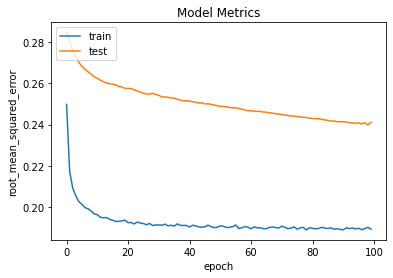

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model Testing

It is time that we try our model. First we prepare a user sample and all the informations needed for that specific user.

In [25]:
import numpy as np

# Get User Sample
user_id = rating.userId.sample(1).iloc[0]

# Get Movies that has been watched by the user
movie_watched_by_user = rating[rating.userId == user_id]
print(movie_watched_by_user)
 
# Get Movies that have not been watched by the user
movie_not_watched = movie[(~movie['id'].isin(movie_watched_by_user.movieId.map(lambda x: str(x)).values))]['id']
movie_not_watched = list(
    set(movie_not_watched).intersection(set(movie_to_movie_encoded.keys()))
)
 
# Encode the movie
movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
# Encode the user
user_encoder = user_to_user_encoded.get(user_id)

user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)
print(user_movie_array)

       userId  movieId  rating  user  movie
86490     580        2     3.5   579    316
86491     580        6     3.5   579    318
86492     580       12     3.0   579   1251
86493     580       16     3.5   579    321
86494     580       19     1.5   579    322
...       ...      ...     ...   ...    ...
87352     580    60760     3.5   579   2717
87358     580    62394     2.0   579   1380
87378     580    68954     4.0   579    648
87386     580    71732     3.0   579   2210
87405     580    74458     4.0   579    653

[397 rows x 5 columns]
[[ 579 1844]
 [ 579 1176]
 [ 579  829]
 ...
 [ 579 1959]
 [ 579 1601]
 [ 579  438]]


Finally, we can retrive the recommended movie for the specified user

In [26]:
ratings = model.predict(user_movie_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]
 
print(f'Showing recommendations for users: {user_id}')
print('====' * 8)
print('Highest Movie Rating from User:')
print('----' * 8)
 
top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    ).head(5).movieId.map(lambda x: str(x)).values
)

 
movie_rows = movie[movie['id'].isin(top_movie_user)][:5]
for row in movie_rows.itertuples():
    print(row.title, ':', row.genres)
 
print('----' * 8)
print('Top 10 Movie Recommendation')
print('----' * 8)
 
recommended_movie = movie[movie['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)

Showing recommendations for users: 580
Highest Movie Rating from User:
--------------------------------
Sleepless in Seattle : Comedy, Drama, Romance
High Noon : Western
Wish You Were Here : Comedy, Drama, Foreign, Romance
License to Wed : Comedy
Confession of a Child of the Century : Drama
--------------------------------
Top 10 Movie Recommendation
--------------------------------
The Celebration : Drama
The Sugarland Express : Crime, Drama
Gentlemen Prefer Blondes : Comedy, Romance
Wuthering Heights : Drama, Romance
The Enforcer : Drama, Action, Crime
Before Sunset : Drama, Romance
Tokyo! : Romance, Drama
The Hunter : Drama, Thriller
Deadlier Than the Male : Action, Comedy, Thriller
Long Pigs : Crime, Horror
